# United Nations

---
### Introduction.
<p><em>For one of my projects at the United Nations (UN), I needed to calculate the duration between the steps in UN job applications. I solved this problem with Python and SQL. Note, all the data in this report is made up and is not related to the UN. Also, the amount of data in this report is limited because this project is about how I solved the problem and not about the data.</em></p>
<img src="assets/un_logo.png">

---
### Importing libraries.

In [6]:
import os
import mysql.connector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---
### Connecting to database.

In [7]:
connection = mysql.connector.connect(
    host = "localhost",
    user = os.environ.get("DB_USER"),
    password = os.environ.get("DB_PASS"),
    database = "development"
)

cursor = connection.cursor(buffered=True)

---
### Creating the [applicants] table.
_I only create a new applicants table if one does not already exist._

In [8]:
query = """
    CREATE TABLE IF NOT EXISTS applicants (
        job_id INT,
        applicant_id INT,
        disposition VARCHAR(255),
        disposition_date DATE
    );
"""

cursor.execute(query)

---
### Adding made-up data.
_I remove any previous data from the applicants' table and then populate it with made-up data._

In [9]:
query = "DELETE FROM applicants"

cursor.execute(query)

query = """
    INSERT INTO applicants
        (job_id, applicant_id, disposition, disposition_date)
    VALUES
        (%s, %s, %s, %s);
"""

rows = [
    (1, 10, "010 Applied", "2019-01-01"),
    (1, 10, "030 Screen", "2019-01-10"),
    (1, 10, "061 Recommended", "2019-01-15"),
    (1, 10, "060 Interview", "2019-01-17"),
    (2, 20, "010 Applied", "2019-02-01"),
    (2, 20, "030 Screen", "2019-02-04"),
    (1, 30, "010 Applied", "2019-03-25"),
    (1, 30, "030 Screen", "2019-04-01")
]

for row in rows:
    cursor.execute(query, row)

---
### Importing MySQL table as a DataFrame.
_By importing the data into a DataFrame, I can manipulate the data in the next steps._

In [10]:
query = "SELECT * FROM applicants;"
df = pd.read_sql_query(query, connection)
df

,job_id,applicant_id,disposition,disposition_date
0,1,10,010 Applied,2019-01-01
1,1,10,030 Screen,2019-01-10
2,1,10,061 Recommended,2019-01-15
3,1,10,060 Interview,2019-01-17
4,2,20,010 Applied,2019-02-01
5,2,20,030 Screen,2019-02-04
6,1,30,010 Applied,2019-03-25
7,1,30,030 Screen,2019-04-01


---
### Adding [next_disposition_date].
_I create two subqueries and assign a row number to each step in the job application process. This action is performed for every applicant and each of their job applications. Note, the two tables are identical to each other. I then join the tables together but with an offset in row numbers. The result is that row number one of the first table will get the disposition date of row number two of the second table. I name the disposition date from the second table: next disposition date._

In [11]:
query = """
    SELECT
        a.job_id,
        a.applicant_id,
        a.disposition,
        a.disposition_date,
        b.disposition_date AS next_disposition_date

    FROM
        (SELECT
            t1.*,
            ROW_NUMBER() OVER (PARTITION BY t1.job_id, t1.applicant_id ORDER BY t1.disposition_date, t1.disposition) AS sequence
        FROM
            applicants t1
        ) AS a

        LEFT JOIN
            (SELECT
                t2.*,
                ROW_NUMBER() OVER (PARTITION BY t2.job_id, t2.applicant_id ORDER BY t2.disposition_date, t2.disposition) AS sequence
            FROM
                applicants t2
            ) AS b
        ON
            a.job_id = b.job_id
            &&
            a.applicant_id = b.applicant_id
            &&
            (a.sequence + 1) = b.sequence
    ORDER BY
        a.job_id, applicant_id, disposition_date, disposition
"""

df = pd.read_sql_query(query, connection)
df

,job_id,applicant_id,disposition,disposition_date,next_disposition_date
0,1,10,010 Applied,2019-01-01,2019-01-10
1,1,10,030 Screen,2019-01-10,2019-01-15
2,1,10,061 Recommended,2019-01-15,2019-01-17
3,1,10,060 Interview,2019-01-17,None
4,1,30,010 Applied,2019-03-25,2019-04-01
5,1,30,030 Screen,2019-04-01,None
6,2,20,010 Applied,2019-02-01,2019-02-04
7,2,20,030 Screen,2019-02-04,None


---
### Calculating the disposition duration.

In [12]:
df.loc[:, "disposition_duration"] = (df.loc[:, "next_disposition_date"] - df.loc[:, "disposition_date"]).dt.days
df

,job_id,applicant_id,disposition,disposition_date,next_disposition_date,disposition_duration
0,1,10,010 Applied,2019-01-01,2019-01-10,9.0
1,1,10,030 Screen,2019-01-10,2019-01-15,5.0
2,1,10,061 Recommended,2019-01-15,2019-01-17,2.0
3,1,10,060 Interview,2019-01-17,None,NaN
4,1,30,010 Applied,2019-03-25,2019-04-01,7.0
5,1,30,030 Screen,2019-04-01,None,NaN
6,2,20,010 Applied,2019-02-01,2019-02-04,3.0
7,2,20,030 Screen,2019-02-04,None,NaN


---
### Visualizing the data.

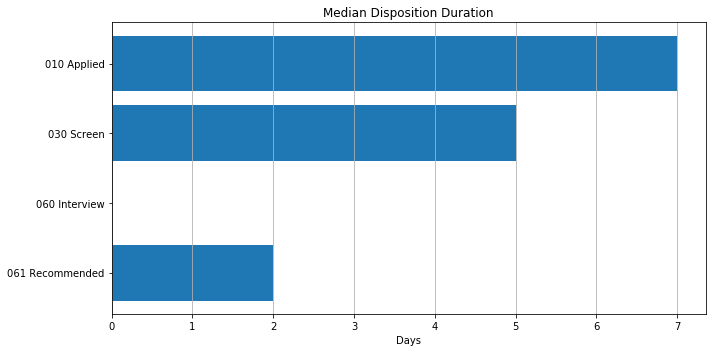

In [13]:
df_sub = df.loc[:, ["disposition", "disposition_duration"]].groupby(by="disposition").median()
dispositions = list(df_sub.index)
median_disposition_durations = df_sub.loc[:, "disposition_duration"].values

fig, ax = plt.subplots(figsize=(10,5))
y_pos = np.arange(len(dispositions))

ax.barh(y=y_pos, width=median_disposition_durations)
ax.set_yticks(y_pos)
ax.set_yticklabels(dispositions)
ax.invert_yaxis()
ax.set_xlabel("Days")
ax.set_title("Median Disposition Duration")
ax.grid(axis="x")

fig.tight_layout()
plt.show()

---
### Conclusion.
_I applied the solution as shown above on millions of data points. In the end, I built a comprehensive and well-designed dashboard in which senior managers can track the performance of hiring managers on defined KPI’s such as screening duration from this report._